In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
train = pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Skillbox_regression-9\train.csv')
train.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
795,1025,304.8,0.0,99.6,196.0,9.8,959.4,705.2,28,30.12
796,1026,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
797,1027,288.0,192.0,0.0,192.0,0.0,932.0,717.8,28,38.80
798,1028,450.1,50.0,0.0,200.0,3.0,1124.4,613.2,28,39.38
799,1029,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30


In [3]:
test = pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Skillbox_regression-9\test.csv')
test.tail()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
225,225,213.7,0.0,174.7,154.8,10.2,1053.5,776.4,100
226,226,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3
227,227,401.8,94.7,0.0,147.4,11.4,946.8,852.1,3
228,228,318.0,0.0,126.0,210.0,6.0,861.0,737.0,28
229,229,255.0,0.0,0.0,192.0,0.0,889.8,945.0,3


In [4]:
train.isna().sum()

Id                    0
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  800 non-null    int64  
 1   Cement              800 non-null    float64
 2   Blast Furnace Slag  800 non-null    float64
 3   Fly Ash             800 non-null    float64
 4   Water               800 non-null    float64
 5   Superplasticizer    800 non-null    float64
 6   Coarse Aggregate    800 non-null    float64
 7   Fine Aggregate      800 non-null    float64
 8   Age                 800 non-null    int64  
 9   Strength            800 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 62.6 KB


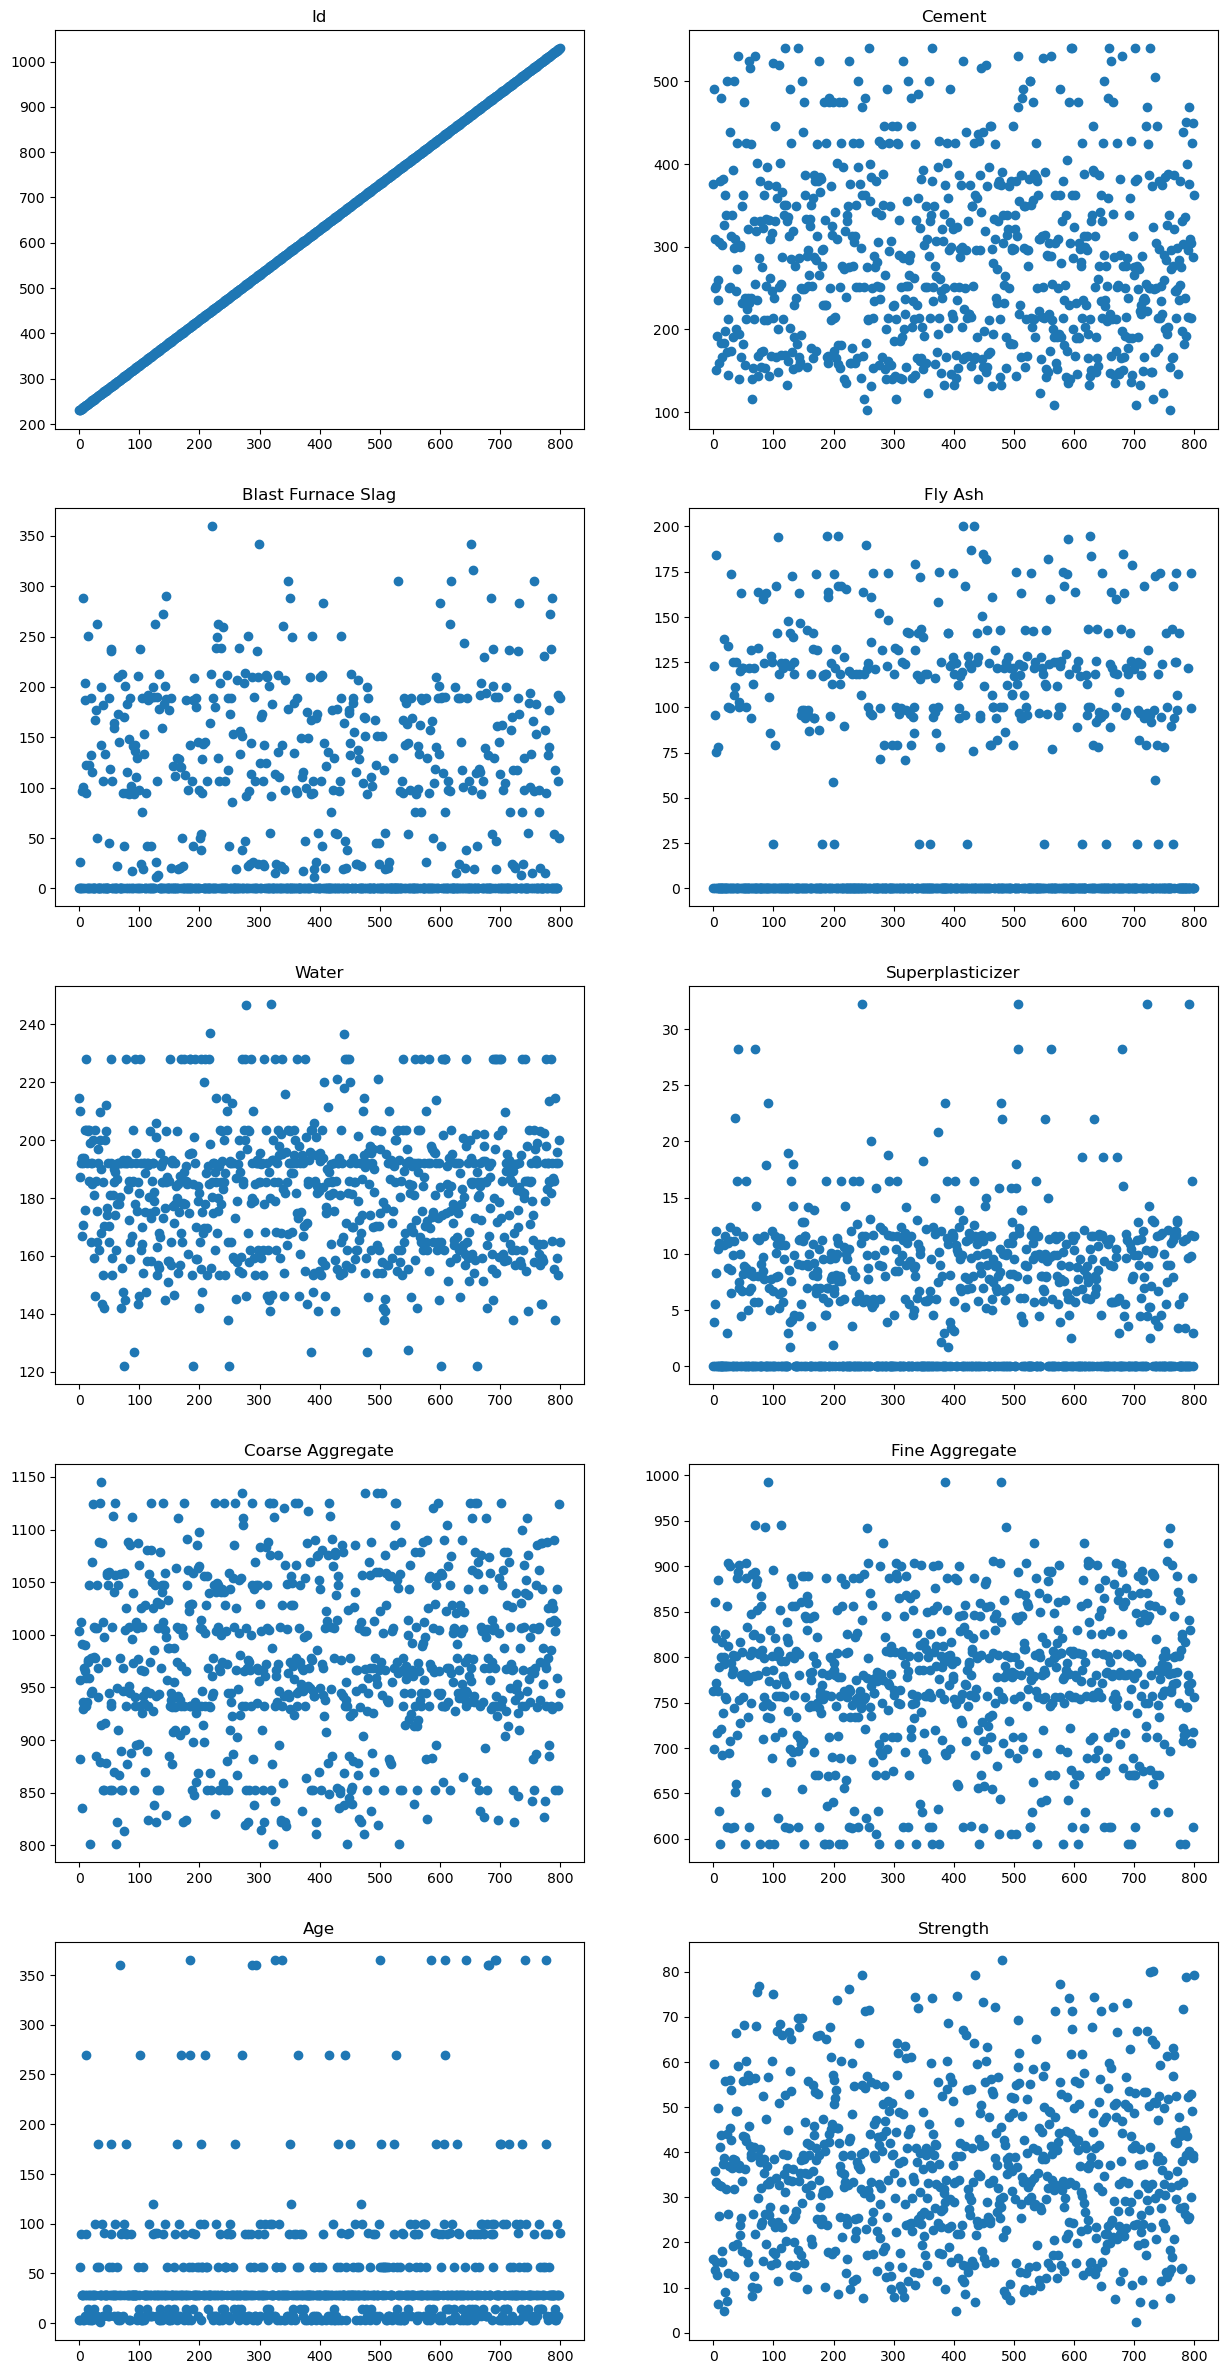

In [22]:
fig, axs = plt.subplots(figsize=(15, 30), nrows=5, ncols=2)
for ax, col in zip(axs.flat, train.columns):
    ax.scatter(train.index, train[col])
    ax.set_title(col)

In [13]:
def quantilecount(dframe, cols: list):

    dframe2 = dframe.copy()

    for col in dframe.drop(columns=cols):

        qMin = dframe[col].quantile(0.25)
        qMax = dframe[col].quantile(0.75)
        iqr = qMax - qMin
        bounds = (qMin - iqr*1.5, iqr*1.5 + qMax)

        dframe2 = dframe2[dframe2[col] >= bounds[0]].copy()
        dframe2 = dframe2[dframe2[col] <= bounds[1]].copy()

    return dframe2.reset_index(drop=True)

In [14]:
train2 = quantilecount(train, ['Strength', 'Id'])
train2

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,230,376.0,0.0,0.0,214.6,0.0,1003.5,762.4,3,16.28
1,231,491.0,26.0,123.0,210.0,3.9,882.0,699.0,56,59.59
2,232,250.0,0.0,95.7,187.4,5.5,956.9,861.2,3,13.82
3,233,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76
4,234,252.1,97.1,75.6,193.8,8.3,835.5,821.4,28,33.40
...,...,...,...,...,...,...,...,...,...,...
727,1025,304.8,0.0,99.6,196.0,9.8,959.4,705.2,28,30.12
728,1026,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
729,1027,288.0,192.0,0.0,192.0,0.0,932.0,717.8,28,38.80
730,1028,450.1,50.0,0.0,200.0,3.0,1124.4,613.2,28,39.38


In [34]:
train2_scaler = StandardScaler().fit_transform(train2.drop(columns=['Id', 'Strength']))
train3 = pd.concat([train2[['Id', 'Strength']],
                   pd.DataFrame(data=train2_scaler, columns=train2.drop(columns=['Id', 'Strength']).columns)], axis=1).reset_index(drop=True)
train3.tail()

,Id,Strength,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
727,1025,30.12,0.232679,-0.834463,0.683749,0.795383,0.679521,-0.211867,-0.913859,-0.184697
728,1026,49.20,1.395123,0.383885,-0.874732,-1.438911,1.929434,-1.576214,1.473486,-0.903652
729,1027,38.80,0.070208,1.366129,-0.874732,0.585096,-1.148710,-0.560265,-0.748491,-0.184697
730,1028,39.38,1.637862,-0.261392,-0.874732,1.005669,-0.589047,1.886151,-2.121313,-0.184697
731,1029,79.30,0.791658,1.331745,-0.874732,-0.839595,1.015319,-0.398781,-0.249760,1.972170


In [41]:
x = train3.drop(columns=['Id', 'Strength'])
y = train3.Strength

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

# DecisionTreeRegressor----------------------------------------------------------------------

In [36]:
dtr = DecisionTreeRegressor(max_depth=50, random_state=42).fit(xtrain, ytrain)
predDTR = dtr.predict(xtest)
root_mean_squared_error(ytest, predDTR)

7.570464093495794

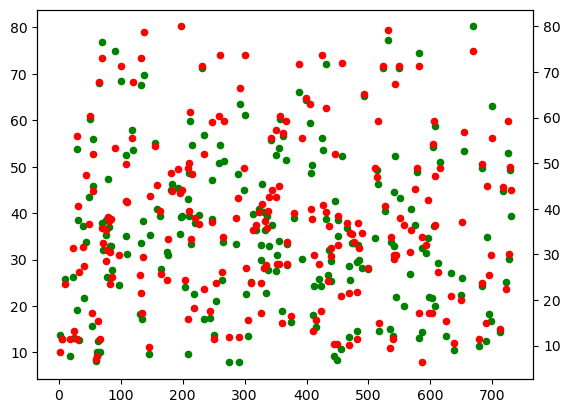

In [37]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(xtest.index, ytest, c='g', s=20)
ax2.scatter(xtest.index, predDTR, c='r', s=20);

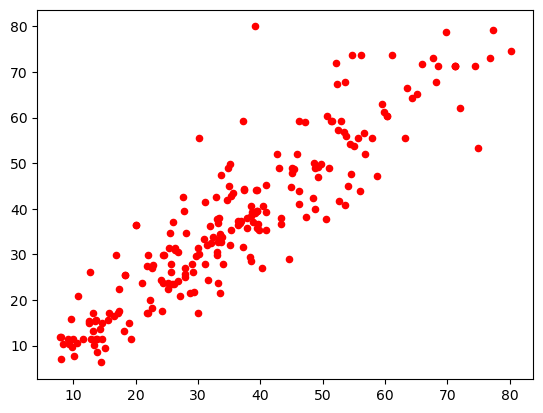

In [38]:
plt.scatter(ytest, predDTR, c='r', s=20);

# NN------------------------------------------------------------------------------------------------------

In [42]:
class Set(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.to_numpy().astype('float32'))
        self.y = torch.tensor(y.to_numpy().astype('float32'))
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.x.shape[0]

In [45]:
traindata = Set(xtrain, ytrain)
trainloader = DataLoader(dataset=traindata, batch_size=60, shuffle=True)

In [46]:
for batch, [x, y] in enumerate(trainloader, 1):
    print(batch, [x.shape, y.shape])

1 [torch.Size([60, 8]), torch.Size([60])]
2 [torch.Size([60, 8]), torch.Size([60])]
3 [torch.Size([60, 8]), torch.Size([60])]
4 [torch.Size([60, 8]), torch.Size([60])]
5 [torch.Size([60, 8]), torch.Size([60])]
6 [torch.Size([60, 8]), torch.Size([60])]
7 [torch.Size([60, 8]), torch.Size([60])]
8 [torch.Size([60, 8]), torch.Size([60])]
9 [torch.Size([32, 8]), torch.Size([32])]


In [59]:
class Net(nn.Module):
    def __init__(self, one, two, three, four, five, six):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
        nn.Linear(one, two),
        nn.Tanh(),
        nn.Linear(two, three),
        nn.LeakyReLU(),
        nn.Linear(three, four),
        nn.LeakyReLU(),
        nn.Linear(four, five),
        nn.LeakyReLU(),
        nn.Linear(five, six),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.seq(x)
        return x

In [60]:
model = Net(xtrain.shape[1], 256, 512, 128, 2, 1)
print(model)

lossfn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=2, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [49]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [61]:
losslist1 = []
losslist2 = []

for batch in range(400):
    for x, y in trainloader:
        
        pred = model(x)
        loss = lossfn(pred, y.unsqueeze(-1))        
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        losslist1.append(loss.item())
        
    losslist2.append(np.array(losslist1).mean())
    losslist1 = []

Mean:  33.094106873737445 

Median:  15.924619065390694 

Min:  4.614819791581896 



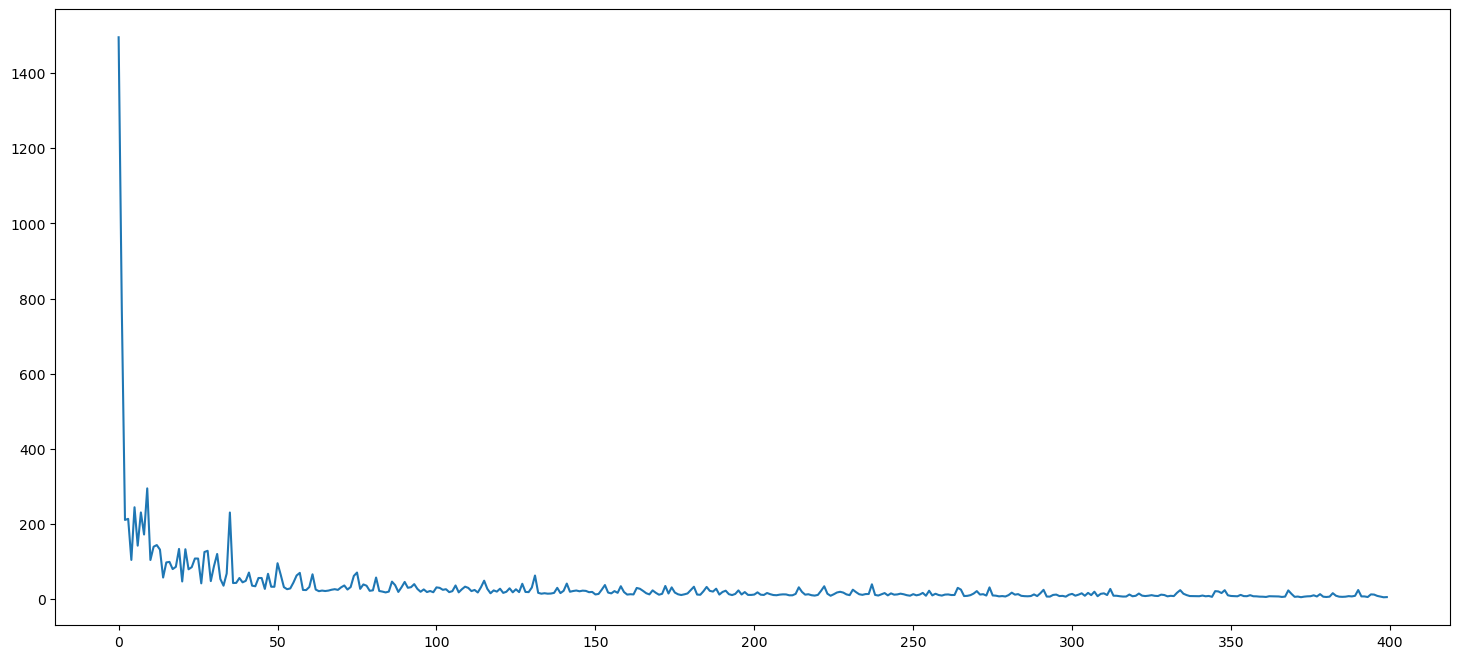

In [62]:
print('Mean: ', np.array(losslist2).mean(), '\n')
print('Median: ', pd.Series(losslist2).median(), '\n')
print('Min: ', min(losslist2), '\n')

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losslist2)
plt.show()

In [63]:
with torch.no_grad():
    predNN = model(torch.tensor(xtest.to_numpy().astype('float32')))

print('RMSE: ', root_mean_squared_error(ytest, predNN), '\n')
print('MSE: ', mean_squared_error(ytest, predNN))

RMSE:  4.99230751455205 

MSE:  24.923134319852867


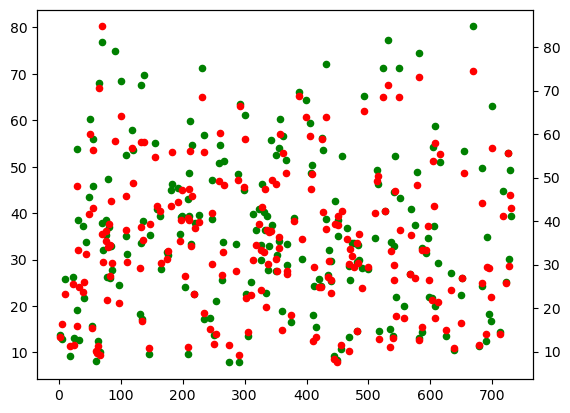

In [64]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(xtest.index, ytest, c='g', s=20)
ax2.scatter(xtest.index, predNN1, c='r', s=20);

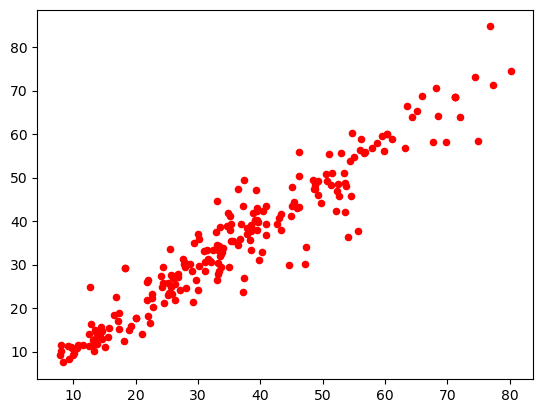

In [65]:
plt.scatter(ytest, predNN1, c='r', s=20);

# Final test modeling-----------------------------------------------------------------------------------

Mean:  106.39748433365821 

Median:  23.773848295211792 

Min:  14.047821760177612 



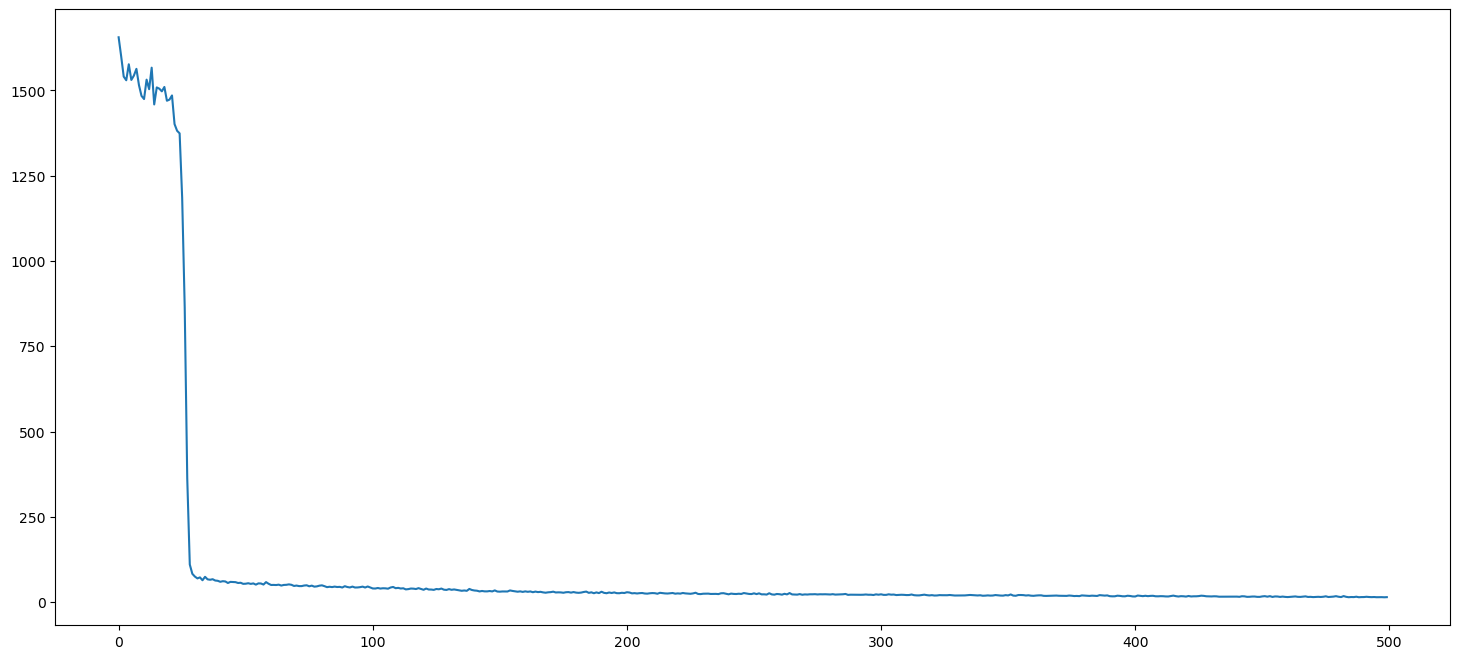

In [66]:
x = train3.drop(columns=['Id', 'Strength'])
y = train3.Strength

model = Net(x.shape[1], 256, 512, 128, 2, 1)

lossfn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.0001)

traindata = Set(x, y)
trainloader = DataLoader(dataset=traindata, batch_size=80, shuffle=True)

losslist1 = []
losslist2 = []

for batch in range(500):
    for x, y in trainloader:
        
        pred = model(x)
        loss = lossfn(pred, y.unsqueeze(-1))        
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        losslist1.append(loss.item())
        
    losslist2.append(np.array(losslist1).mean())
    losslist1 = []
    
    
print('Mean: ', np.array(losslist2).mean(), '\n')
print('Median: ', pd.Series(losslist2).median(), '\n')
print('Min: ', min(losslist2), '\n')

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(losslist2)
plt.show()

In [67]:
test_scaler = StandardScaler().fit_transform(test.drop(columns=['Id']))
test2 = pd.concat([test[['Id']],
                   pd.DataFrame(data=test_scaler, columns=test.drop(columns=['Id']).columns)], axis=1).reset_index(drop=True)


test3 = test2.drop(columns=['Id'])


with torch.no_grad():
    predNNtest = model(torch.tensor(test3.to_numpy().astype('float32')))

In [68]:
predicted_Strength = pd.DataFrame(data={'Id': test2['Id'], 'Strength': predNNtest.squeeze()})
predicted_Strength.to_csv('predicted_Strength_ver8.csv', index=False)

# Tests

In [ ]:
model1 = Net(x.shape[1], 512, 1024, 512, 2, 1)

In [167]:
for i in model1.parameters():
    print(i.shape)

torch.Size([512, 8])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([2, 512])
torch.Size([2])
torch.Size([1, 2])
torch.Size([1])


In [ ]:
Line = nn.Linear(2, 1, bias=True)

import torch.nn.init as init
init.xavier_uniform_(Line.weight)
init.zeros_(Line.bias)

Line(torch.tensor([1,2], dtype=torch.float32))

print('weight: ', Line.weight)
print('bias: ', Line.bias)